# LeNet for Traffic Sign Recognition

## Objective

This objective of this project is to train a classifier using Tensorflow and the German Traffic Signs Dataset.  The neural network architecture used here is a modified version of the LeNet model.

After training is completed, the trained classifier accuracy is evaluated using images of traffic signs that were not part of the training dataset.  This is all done within this Jupyter Notebook.


# Loading and Exploring the Data

The code below loads images from two different pickle datasets.  The first data set contains the training images that will be used for training.  The second data set contains the images for evaluation the performance of the classifier.

In [3]:
import pickle
import tensorflow as tf


training_file = './traffic-signs-data/train.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']


## Dataset Summary 

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Contained below is the code used to output the details for the training and testing image datasets.

In [4]:
# Number of training examples
n_train = len(y_train)

# Number of testing examples
n_test = len(y_test)

# shape of traffic sign image
image_shape = train['features'][1].shape

# unique classes/labels there in the dataset
n_classes = len(set(train['labels']))


print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


## Visualizing Dataset with Matplotlib

Next, we visualize the German Traffic Signs Dataset using the pickled file(s) using matplotlib.  This shows several smaples from the dataset of different signs with a label of what the sign type is.  Also shown is a graph representing the distribution of each sign type across the dataset.


/Users/chris/anaconda/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/chris/anaconda/envs/CarND-Traffic-Sign-Classifier-Project/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


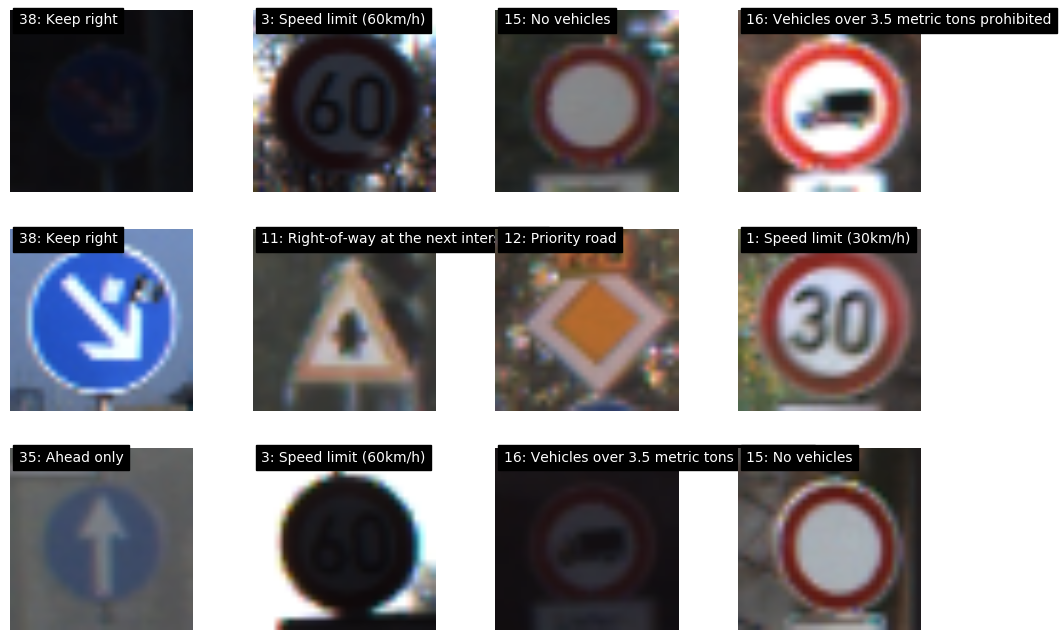

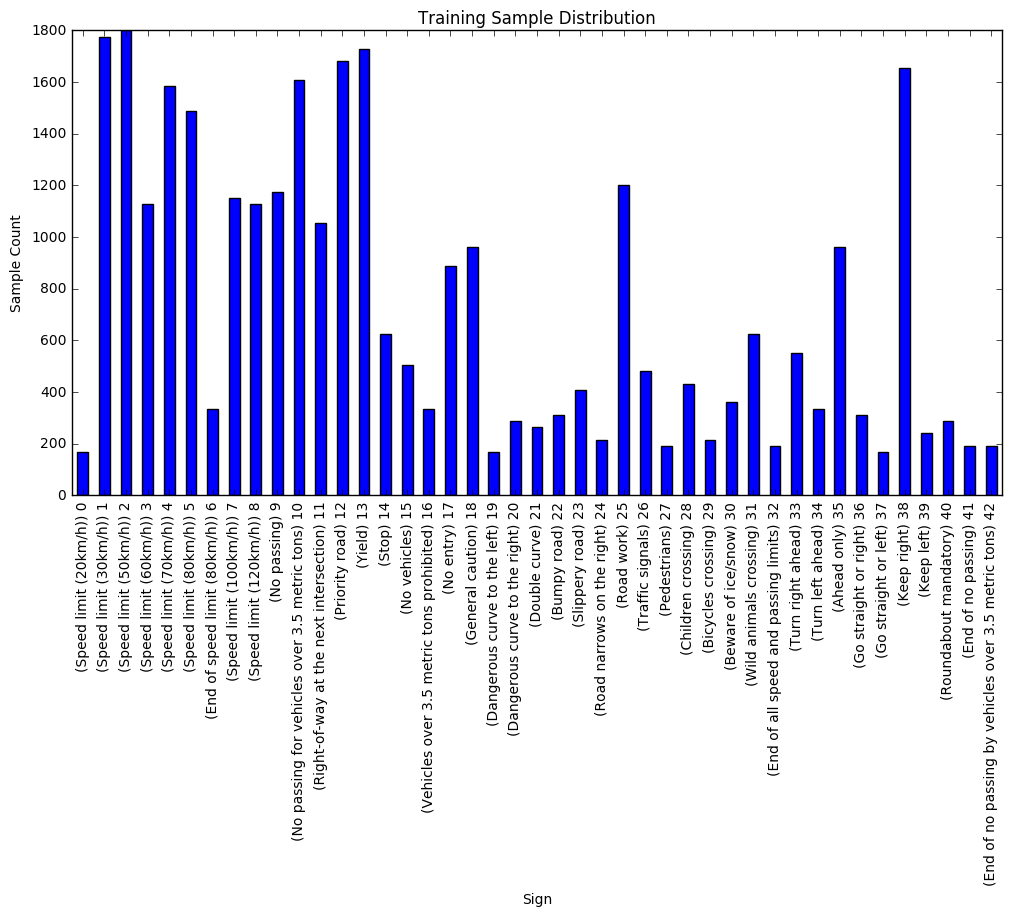

In [6]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import csv 
import matplotlib.pyplot as plt
import matplotlib.pyplot as gridspec
from sklearn.utils import shuffle
import numpy as np
import operator
# Visualizations will be shown in the notebook using matplotlib.
%matplotlib inline

idx = 30000
x_train = train['features']
y_train = train['labels']

def lookupSignNames():
    signnames = {}
    with open('signnames.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        for rows in reader:
            signnames[rows[0]] = rows[1]
    return signnames

def showSamplesPerSign(features, labels, signnames):
    samplesPerSign =  [0] * (len(signnames) - 1)
    
    for key, signname in signnames.items():
        if key != "ClassId":
            samplesPerSign[int(key)] = 0
        
    for idx, feature in enumerate(features):
        key = str(labels[idx])
        samplesPerSign[int(key)] += 1

    # show prediction confidence graph
    plt.figure(figsize=(12, 6))
    series = pd.Series.from_array(samplesPerSign)

    x_labels = range(0,len(samplesPerSign))
    ax = series.plot(kind='bar')
    ax.set_title("Training Sample Distribution")
    ax.set_xlabel("Sign")
    ax.set_ylabel("Sample Count")
    ax.set_xticklabels(["(" + (signnames[str(x)] + ") " + str(x)) for x in x_labels])

    plt.show()


def split_data(features, labels):
    X, y = shuffle(features, labels)
    training = {'features': [], 'labels': []}
    validate = {'features': [], 'labels': []}
    test = {'features': [], 'labels': []}
    
    label_counts = [0] * len(set(y))
    
    for idx, feature in enumerate(X):
        label = y[idx]
        label_counts[label] += 1
        
        if label_counts[label] <= 8:
            training['features'].append(feature)
            training['labels'].append(label)
        elif label_counts[label] == 9:
            validate['features'].append(feature)
            validate['labels'].append(label)
        else:
            test['features'].append(feature)
            test['labels'].append(label)
            label_counts[label] = 0
    
    training['features'] = np.array(training['features'])
    validate['features'] = np.array(validate['features'])
    test['features'] = np.array(test['features'])

    return training, validate, test 

def countOf(value, array):
    count = 0
    for element in array:
        if(element == value):
            count += 1
    return count

signnames = lookupSignNames()

# show some images at random
plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3, 4)

for x in range(0,12):
    index = random.randint(0, len(x_train))
    image = x_train[index].squeeze()

    ax = plt.subplot(gs[x])
    plt.axis('on')
    ax.set_aspect('equal')
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    plt.text(1,2,str(y_train[index]) + ": " + signnames[str(y_train[index])], color='w',backgroundcolor='k')

    plt.imshow(image)
    plt.imshow(image)
    plt.axis('off')

plt.show()

training, validation, test = split_data(train['features'], train['labels'])

showSamplesPerSign(training['features'], training['labels'], signnames)

----

# Preprocessing Data

In order to prepare our data for training, preprocessing the dataset is necessary.  

The preprocessing used here is minimal.  Each image in the training set is converted to grayscale and then the rgb values are normalized.  Converting to grayscale allows us to reduce the dimensions of the training data from a 32x32x3 sample to a 32x32x1 sample.  In addition to reducing the dimensionality of each training sample, this also prevented the nueral network from relying on color data, which may vary significantly based off of lighting conditions.

One other approach I experimented with was using histogram equalization to try to increase the contrast of the images.  The idea was that this may help the neural network better distinguish features of the signs from the background.  In practice, this didn't seem to impact the prediction accuracy, so it wasn't used in the final implementation.

In [7]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import matplotlib.gridspec as gridspec
import time
import matplotlib.gridspec as gridspec

%matplotlib inline

def generate_data(features, labels):
    label_counts = {}
    
    for label in labels:
        label_counts[label] = { 'count': 0, 'start_idx': -1 }
    
    max_label_count = 0
    prev_label = -10
    
    for idx, feature in enumerate(features):
        label = labels[idx]
        if prev_label != label:
            label_counts[label]['start_idx'] = idx
            prev_label = label
        
        label_counts[label]['count'] += 1
        count = label_counts[label]['count']
            
        if max_label_count < count:
            max_label_count = count

    new_features = []
    new_labels = []
    
    for key in label_counts.keys():
        details = label_counts[key]
        count = details['count']
        start_idx = details['start_idx']
        diff = int(max_label_count * 1.25) - count
        
        for x in range(diff):
            src_image_idx = random.randint(start_idx, start_idx + count - 1)
            new_features.append(transform_image(features[src_image_idx],10,5,5))
            new_labels.append(key)

    return np.concatenate((features, new_features), axis=0), np.concatenate((labels, new_labels), axis=0)
            
def transform_image(img,ang_range,shear_range,trans_range):
    ''' 
    This method is not my own work, it was obtained from:
    https://medium.com/@vivek.yadav/dealing-with-unbalanced-data-generating-additional-data-by-jittering-the-original-image-7497fe2119c3#.hl94b7jvr
    
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

def preprocess_data(features, labels):
    x_train, y_train = shuffle(features, labels)
    
    processed_features = np.empty([len(x_train), 32, 32, 1])
    
    for idx, feature in enumerate(x_train):
        # convert to grayscale
        preprocessed_feature = cv2.cvtColor(feature, cv2.COLOR_RGB2GRAY)

        # equalize
        preprocessed_feature = cv2.equalizeHist(preprocessed_feature)
        
        # normalize, convert pixel values from range of 0 to 255 to -1 to 1
        preprocessed_feature = [ (x - 127.5) / 255.0 for x in preprocessed_feature]
        
        
        preprocessed_feature = np.expand_dims(preprocessed_feature, axis=2)
        processed_features[idx] = preprocessed_feature

    return processed_features, y_train


# Splitting Up Images And Image Generation

The sign images where split up into training, validation, and test sets.  The training set contained 80% of the available images, the validation set contained approximately 10% of the images, the testing set contained roughly 10% of the available images.  This distribution allowed for a large training set to be used at the cost of accurate validation and a more limited test set for evaluating the performance of the network.

I also experimented with generating data.  Since there was not a proportionate representation of images for each sign, I thought generating data to produce an equal number of images for each sign type would improve results, as it would be less biased towards signs with a larger number of samples in the training set.

The approach I used was to use samples from the existing data set and apply shearing and random rotations (identical to the approach described here  https://medium.com/@vivek.yadav/dealing-with-unbalanced-data-generating-additional-data-by-jittering-the-original-image-7497fe2119c3#.hl94b7jvr).  I hoped this would improve the performance of the model on images that were taken from various angles.  

The first solution I implemented found the sign with the most images in the sample set.  It then generated images for all other signs until the total number of images for each sign was equal.  After evaluating this approach, I realized that all signs need some generated data.  Next, I generated images so that each sign's sample count would be twice the number of the sign with largest amount of data.  This means that the sign with the most original images would have 50% of its data generated and every other sign would have more than 50% of its data generated.

With the size of the training set now significantly larger, it took much longer to train.  After a few epochs, I noticed that my accuracy was consistently coming to 2.3%, which is no better than randomly guessing a classification for a sign.  For this reason, I abandonned generating any additional samples for the training set in the final implementation.

In [8]:
def split_data(features, labels):
    X, y = shuffle(features, labels)
    training = {'features': [], 'labels': []}
    validate = {'features': [], 'labels': []}
    test = {'features': [], 'labels': []}
    
    label_counts = [0] * len(set(y))
    
    for idx, feature in enumerate(X):
        label = y[idx]
        label_counts[label] += 1
        
        # 80% of samples are used for training set
        if label_counts[label] <= 8:  
            training['features'].append(feature)
            training['labels'].append(label)
        # 10% of samples used for validation set
        elif label_counts[label] <= 9:
            validate['features'].append(feature)
            validate['labels'].append(label)
        # 10% if samples are used for test set
        else:
            test['features'].append(feature)
            test['labels'].append(label)
            if(label_counts[label] == 10):
                label_counts[label] = 0
    
    training['features'] = np.array(training['features'])
    validate['features'] = np.array(validate['features'])
    test['features'] = np.array(test['features'])

    return training, validate, test 

# Step 3: Defining the Neural Network Architecture

The final architecture was almost identical the the infamous LeNet implementation. Dropout was introduced between the fully connected layers to help prevent the model from overfitting to the training set.  The final architecture is as follows: 

- The first layer was a convolutional layer which took in the grayscale images from the training set (with dimensions of 32x32x1) and outputs a 28x28x6 sample
- ReLU activation is applied
- Max pooling is performed, transforming the 28x28x6 sample to a 14x14x6 sample
- The second layer is another convolutional layer, taking in a 14x14x6 sample and producing a 10x10x16 sample
- ReLU activation is applied again
- Max pooling is performed, resulting in a 5x5x16 sample
- The 5x5x16 sample is flattened to 400 samples 
- The 400 samples are fed into a fully connected layer resulting in 120 outputs
- ReLU activation is appled to the result
- Dropout is applied to help prevent overfitting
- The 120 samples are fed into another fully connected layer, resulting in 84 outputs
- ReLU activation is appled to the result
- Dropout is applied to help prevent overfitting
- The 84 samples are fed into the final fully connected layer, resulting in 42 outputs (one for each sign)

In [10]:
def LeNet(x): 
    class_count = 43
    mu = 0
    sigma = 0.001

    """
    LeNet implementation
      x: feature layer
      class_count: number of classifications in y
      mu: mean for initializing weights
      sigma: standard deviation for intializing weights
    """
    # L1 - Convolutional: 32x32x1 => 28x28x6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="conv1W")
    conv1_b = tf.Variable(tf.zeros(6), name="conv1b")
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation
    conv1 = tf.nn.relu(conv1)

    # Max pooling: 28x28x6 => 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # L2 - Convolutional: 14x14x6 => 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="conv2W")
    conv2_b = tf.Variable(tf.zeros(16), name="conv2b")
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation
    conv2 = tf.nn.relu(conv2)

    # Max Pooling: 10x10x16 => 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten: 5x5x16 => 400.
    fc0 = flatten(conv2)

    # L3 - Fully Connected: 400 => 120
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma), name="fc1W")
    fc1_b = tf.Variable(tf.zeros(120), name="fc1b")
    fc1 = tf.add(tf.matmul(fc0, fc1_W), fc1_b)

    # Activation
    fc1 = tf.nn.relu(fc1)
    
    # Dropout
    fc1 = tf.nn.dropout(fc1, dropout_keep_prob)

    # L4 - Fully Connected: 120 => 84
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma), name="fc2W")
    fc2_b  = tf.Variable(tf.zeros(84), name="fc2b")
    fc2 = tf.add(tf.matmul(fc1, fc2_W), fc2_b)

    # Activation.
    fc2 = tf.nn.relu(fc2)
    
    # Dropout
    fc2 = tf.nn.dropout(fc2, dropout_keep_prob)

    # L5 - Fully Connected:  84 => class_count
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, class_count), mean = mu, stddev = sigma), name="fc3W")
    fc3_b  = tf.Variable(tf.zeros(class_count), name="fc3b")  
    logits = tf.add(tf.matmul(fc2, fc3_W), fc3_b, name="logits")

    return logits


# Step 4: Training 

The LeNet-5 architecture was chosen initially for the following reasons:

- Relatively easy to understand and implement
- Proven track record of good performance for image recongition
- Well studied and documented
- Not Hardware Restrictive - 100's of epochs can be run on given data set in a couple hours on high end personal PC


My approach was to implement the LeNET-5 architecture, adjust hyper parameters to optimize performance, and then come back and evaluate whether a more custom solution was needed.  

After spending a good amount of time adjusting the hyper parameters and introducing dropout to the model to reduce overfitting, I believed that the performance of the LeNet architecture was likely better than another convolutional architecture I would have been able to create within the hardware constraints and time constraints for this project.

A lot of trial and error went into determining values for the hyperparameters used in this model.  Out of the values I experimented with, the optimal hyperparametrs I found are as follows:

- Epohcs: 400  Realistically this could probably be much lower.  After running and looking over the validation accuracy after each epoch, it seems no real gain using this many epochs.  I wasn't too concerned about overfitting since I was using a fairly agressive dropout rate on the fully connected layers.
- Batch Size: 64
- Optimizer: AdamOptimizer
- Learning Rate: 0.001  This proved to be a low enough value to get accurate results without getting stuck in a local minima.
- Dropout Rate: 0.6  Keeping 60% of the values from the fully connected layers seemed to be sufficient for preventing overfitting and still acheiving accurate predictions

I suspect the performance of my LeNET implementation could be even further increased by further exploring other preprocessing approaches on the training set and generating more training samples for the existing image set.

In the future, I plan to experiment with this architecture a bit more, possibly adding additional convolutional layers and trying to capture more lower level features.


In [ ]:

def evaluate_data(X_data, y_data, batch_size):
    """
    Given a dataset as input returns the accuracy.
    """
    sample_count = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, sample_count, batch_size):
        batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        accuracy = sess.run(accuracy_op, feed_dict={x: batch_x, y: batch_y, dropout_keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
        
    return total_accuracy / sample_count

"""
Main
"""
# using generated data
# x_data, y_data = generate_data(train['features'], train['labels'])
# x_data, y_data = preprocess_data(x_data, y_data)

# using default data
x_data, y_data = preprocess_data(train['features'], train['labels'])

training, validation, test = split_data(x_data, y_data)

x_train, y_train = training['features'], training['labels']
x_validation, y_validation = validation['features'], validation['labels']
x_test, y_test = test['features'], test['labels']


FEATURE_COUNT = len(x_train)
CLASS_COUNT  = len(set(y_train))

EPOCHS = 400
BATCH_SIZE = 64
MEAN = 0
SIGMA = 0.001
LEARNING_RATE = 0.001
DROPOUT_KEEP_PROB = 0.6

x = tf.placeholder(tf.float32, (None, 32,32,1), name="x")
y = tf.placeholder(tf.int32, (None), name="y")
one_hot_y = tf.one_hot(y, CLASS_COUNT)

dropout_keep_prob = tf.placeholder(tf.float32)

# training pipeline
logits = LeNet(x)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))
opt = tf.train.AdamOptimizer(LEARNING_RATE)
train_op = opt.minimize(loss_op)

# evaluation 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    steps_per_epoch = FEATURE_COUNT // BATCH_SIZE
    num_examples = FEATURE_COUNT
    
    total_start_time = time.time()
    max_accuracy = 0
    
    # Train model
    for i in range(EPOCHS):
        print("Processing epoch: ", i + 1, "/", EPOCHS)
        start_time = time.time()
        x_train, y_train = shuffle(x_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            sess.run(train_op, feed_dict={x: batch_x, y: batch_y, dropout_keep_prob: DROPOUT_KEEP_PROB})
            
        print("Finished training epoch #", i + 1, "in: {:.3f}".format(time.time() - start_time), "seconds.")
        
        # evaluate against validation data
        validation_accuracy = evaluate_data(x_validation, y_validation, BATCH_SIZE)
        print("Validation accuracy = {:.3f}".format(validation_accuracy))
    
    print("TOTAL TIME: {:.3f}".format(time.time() - total_start_time))

    # Evaluate on the test data
    test_accuracy = evaluate_data(x_test, y_test, BATCH_SIZE)
    print("Test accuracy = {:.3f}".format(test_accuracy))

    # Save trained model
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Processing epoch:  1 / 400
Finished training epoch # 1 in: 15.308 seconds.
Validation accuracy = 0.103
Processing epoch:  2 / 400
Finished training epoch # 2 in: 15.256 seconds.
Validation accuracy = 0.269
Processing epoch:  3 / 400
Finished training epoch # 3 in: 15.138 seconds.
Validation accuracy = 0.503
Processing epoch:  4 / 400
Finished training epoch # 4 in: 15.039 seconds.
Validation accuracy = 0.669
Processing epoch:  5 / 400
Finished training epoch # 5 in: 15.000 seconds.
Validation accuracy = 0.762
Processing epoch:  6 / 400
Finished training epoch # 6 in: 15.105 seconds.
Validation accuracy = 0.777
Processing epoch:  7 / 400
Finished training epoch # 7 in: 13.338 seconds.
Validation accuracy = 0.831
Processing epoch:  8 / 400
Finished training epoch # 8 in: 12.791 seconds.
Validation accuracy = 0.855
Processing epoch:  9 / 400
Finished training epoch # 9 in: 12.762 seconds.
Validation accuracy = 0.871
Processing epoch:  10 / 400
Finished training epoch # 10 in: 12.473 secon

### Implementation


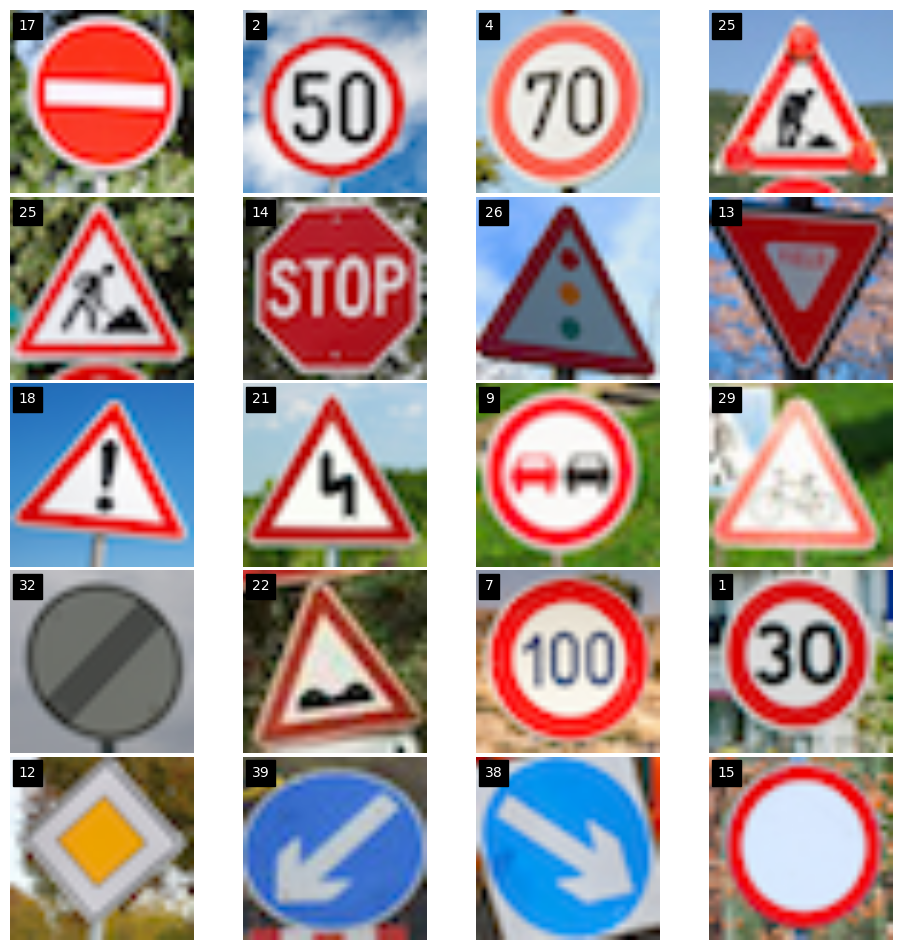

In [8]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_names = [
    'do_not_enter.png',
    '50_km_hr.png', 
    '70_km_hr.png', 
    'road_work.png', 
    'road_work_2.png', 
    'stop_usa.png',
    'traffic_signal.png', 
    'yield_usa.png',
    'general_caution.png', 
    'double_curve.png',
    'no_passing.png',
    'bicycle_crossing.png',
    'end_of_limits.png',
    'bumpy_road.png',
    '100_km_hr.png',
    '30_km_hr.png',
    'priority_road.png',
    'keep_left.png',
    'keep_right.png',
    'no_vehicles.png'
]

test_labels = [17,2,4,25,25,14,26,13, 18, 21, 9, 29, 32,22,7,1,12,39,38,15]
test_images = []

plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(5, 4)
gs.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 

                       
for idx, image_name in enumerate(image_names):
    image = cv2.imread('test_images/' + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax = plt.subplot(gs[idx])
    plt.axis('on')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    
    plt.text(1,3,str(test_labels[idx]), color='w',backgroundcolor='k')

    plt.imshow(image)
    plt.axis('off')

    test_images.append(image)

plt.show()




# Testing Model on New Images

Below are five pictures of traffic signs taken from the web.  These were not part of any of the datasets used for training or testing the model.  I run them through the classifier to see how it does against these new images.  Some of these images are local and actually different from any of the signs used.

Below are my concerns for each.

**Speed Limit 70km/h**
I'm concerned about how the model will perform on the speed limits signs, because each speed limit sign looks very simliar to the other speed limit signs.  It is also concerning that there each speed limit sign has a different number of samples than the others.  I expect this may cause the speed limit sign with the sample count to be favored over the others.

** Road Work Sign (Variant) ** I added this image to see if the model would be able to recognize a road work sign that is slightly different than the training data.  This sign has reflectors on the edges and the actually symbol of the man working is different from what the road work signs in the training set look like.  With a bit of luck, the sign may be close enough to still be recognized.

** North American Yield Sign ** This is a North American Yield sign, which varies slightly from the training in that the red borders are thicker than the images in the training data and the text "Yield" acutally appears on the sign. 

** Bicycle Crossing Sign ** I chose this sign to test how well the model would work on images with lots of glare.  From a human perspective the symbol of the bicycle is difficult to make out and the sign looks rather washed out. 

** Keep Right Sign (Variant) ** This sign is actually different from the training data in that it was taken from a cardboard tent/fold up sign.  Because the sign is folded, the angle of rotation may be slightly different.  The coloration of the sign also appears to be lighter than the signs in the training data.

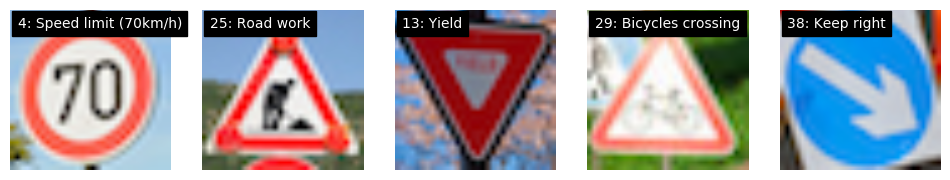

In [9]:
five_images_idx = []

for idx, name in enumerate(image_names):
    if name in ['bicycle_crossing.png', '70_km_hr.png', 'yield_usa.png', 'road_work.png', 'keep_right.png']:
        five_images_idx.append(idx)

fig_idx = 0

plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(1, len(five_images_idx))

for idx, image_idx in enumerate(five_images_idx):
    ax = plt.subplot(gs[idx])
    plt.axis('on')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    
    plt.text(1,3,str(test_labels[image_idx]) + ": " + signnames[str(test_labels[image_idx])], color='w',backgroundcolor='k')
    plt.imshow(test_images[image_idx])
    plt.axis('off')


plt.show()

In [10]:

test_x, test_y = preprocess_data(test_images, test_labels)
test_x = test_x.astype(np.float32, copy=False)

with tf.Session() as sess:   
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    softmax = sess.run( tf.nn.softmax(logits), feed_dict={x: test_x, dropout_keep_prob: 1.0})

    top_k_values, top_k_indices = sess.run(tf.nn.top_k(softmax, 3))

    predictions = []
    for value in softmax:
        predictions.append(np.argmax(value))



## Performance 'In The Wild'

Due to the limited number of captured pictures used, it is hard to draw conclusions confidently as to how well this model will perform on pictures "in the wild".  From the limited test set used here, it does appear that the model does do poorer on the captured images than on the testing set of images from the dataset.  

Running the model on the provided test images from the dataset achieved an accuracy of approximately 97%.  Running the model on the 20 captured images produced 2 prediction errors resulting in 90% accuracy.

Applying the trained model to a limited number of outside images provides some hints as to what signs the model may be good at recognizing and what signs it may struggle with.  The model recognized 90% of the 20 new images it was applied to.  

Most of the images it predicted correctly, it did so with very high confidence.  The exception to this was a stop sign which it identified as a road work sign and a general caution sign it identified as a traffic signal.  

The model was 72.3% confident in its prediction of a road work sign for the stop sign.  It had a confidence of 27.68% that it was a stop sign, which was in fact the correct prediction. 

The model was 67.2% confident in its prediction for the general caution sign.  It had a confidence of 32.8% that it was a road work sign, which was in fact the correct prediction. 

Even though the model did make two wrong predictions, it is a bit reassuring to note that the right choice was always the second highest prediction.  It is also worth noting that the model wasn't overly confident that the wrong answer was correct.


RESULTS FROM RUNNING AGAINST CAPTURED IMAGES

Accuracy:  90.0 %  ( 18 / 20 )

acutal:    [15, 9, 25, 14, 22, 38, 39, 13, 25, 12, 21, 26, 4, 17, 18, 29, 1, 7, 32, 2]
predicted: [15, 9, 25, 25, 22, 38, 39, 13, 25, 12, 21, 26, 4, 17, 26, 29, 1, 7, 32, 2]


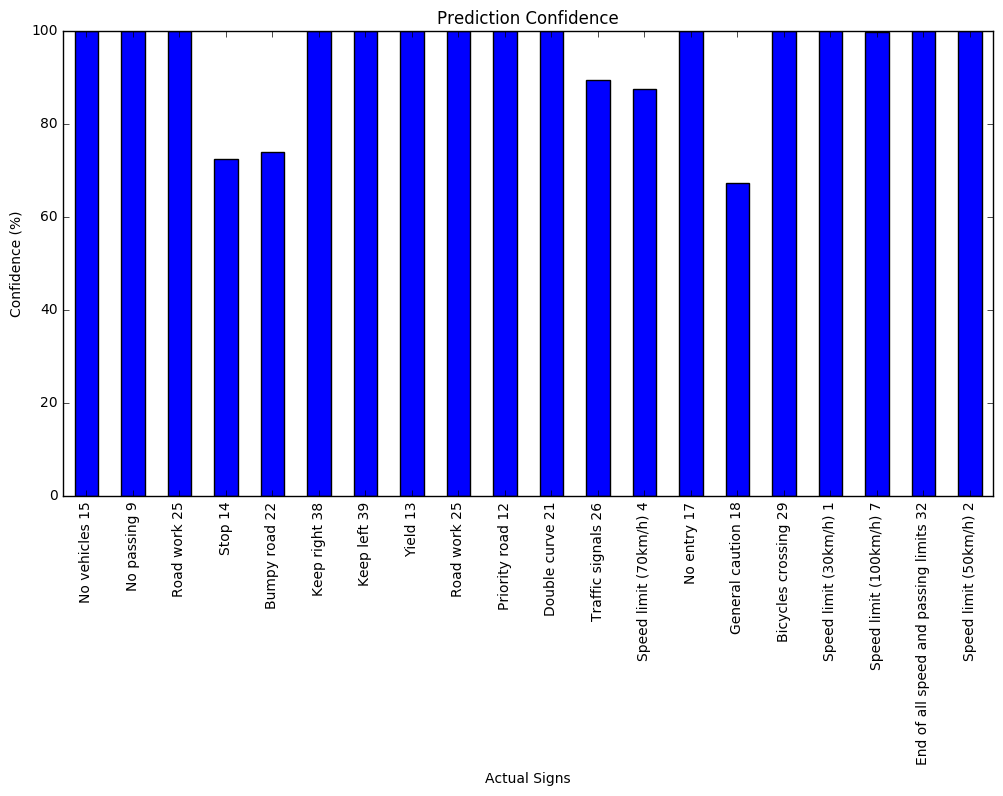


Incorrect Prediction Summary
---------------------------------------------------------------

 Actual:                      14 : Stop
 Predicted:                   25 : Road work
 Prediction Confidence:       72.32%
 Was In top 3 predictions? :  YES
 Top 3 Predictions:           25 : Road work (72.32%) ,  14 : Stop (27.68%) ,  13 : Yield (0.0001301%)

 Actual:                      18 : General caution
 Predicted:                   26 : Traffic signals
 Prediction Confidence:       67.19%
 Was In top 3 predictions? :  YES
 Top 3 Predictions:           26 : Traffic signals (67.19%) ,  18 : General caution (32.81%) ,  37 : Go straight or left (0.003302%)


In [29]:
import pandas as pd
    
correct = 0
incorrect = 0
incorrect_indexes = []
prediction_confidence = []
    
for idx, prediction in enumerate(predictions):
    prediction_confidence.append(top_k_values[idx][0] * 100)
    if test_y[idx] == prediction:
        correct += 1
    else:
        incorrect += 1
        incorrect_indexes.append(idx)

print("======================================================================")
print("RESULTS FROM RUNNING AGAINST CAPTURED IMAGES")
print("======================================================================")
print("")
print("Accuracy: ", correct/len(predictions) * 100.0, "%  (", correct, "/", len(predictions), ")")
print("")
print("acutal:   ", test_y)
print("predicted:", predictions)

        
signNames = lookupSignNames()
        
    
# show prediction confidence graph
plt.figure(figsize=(12, 6))
series = pd.Series.from_array(prediction_confidence)

x_labels = test_y
ax = series.plot(kind='bar')
ax.set_title("Prediction Confidence")
ax.set_xlabel("Actual Signs")
ax.set_ylabel("Confidence (%)")
ax.set_xticklabels([(signNames[str(x)] + " " + str(x)) for x in x_labels])

rects = ax.patches

plt.show()

if incorrect > 0:
    print("")
    print("Incorrect Prediction Summary")                                        
    print("---------------------------------------------------------------")
    for idx in incorrect_indexes:

        predicted_number = predictions[idx]
        predicted_sign = signNames[str(predicted_number)]
            
        actual_number = test_y[idx]
        actual_sign = signNames[str(test_y[idx])]

        prediction1_details = '{} : {} ({:.4}%)'.format(top_k_indices[idx][0], signNames[str(top_k_indices[idx][0])], top_k_values[idx][0] * 100.0,3)
        prediction2_details = '{} : {} ({:.4}%)'.format(top_k_indices[idx][1], signNames[str(top_k_indices[idx][1])], top_k_values[idx][1] * 100.0,3)
        prediction3_details = '{} : {} ({:.4}%)'.format(top_k_indices[idx][2], signNames[str(top_k_indices[idx][2])], top_k_values[idx][2] * 100.0,3)

        print("")
        print(" Actual:                     ", actual_number, ":", actual_sign)
        print(" Predicted:                  ", predicted_number, ":",  predicted_sign)
        print(" Prediction Confidence:      ",  str(round(top_k_values[idx][0] * 100, 2)) + "%")
        print(" Was In top 3 predictions? : ", "YES" if predicted_number in top_k_indices[idx] else "NO")
        print(" Top 3 Predictions:          ", prediction1_details, ", ", prediction2_details, ", ", prediction3_details )
